# Regresión con redes neuronales

El dataset de diabetes, consta de 10 biométricos que se ocupan para precedir la glucosa en un humano. En esta práctica utilizaremos una red neuronal sencilla que simule una regresión lineal.

In [ ]:
# Cargamos los paquetes de PyTorch que necesitaremos
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Dataset para regresión
from sklearn.datasets import load_diabetes
# Para dividir en conjunto de entrenamiento y validación
from sklearn.model_selection import train_test_split

# Paquetes para manejo y visualización de los datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Para controlar la generación de parámetros aleatorios
import random

Por cuestiones de reproducibilidad, nos gustaría tener los mismos resultados. Cabe aclarar que **no se recomienda hacer esto** en un entorno fuera de la enseñanza.

In [ ]:
# Definir una semilla aleatoria para garantizar reproducibilidad de resultados
random_seed = 1
# Establecer la semilla aleatoria para PyTorch
torch.manual_seed(random_seed)
# Establecer la semilla aleatoria para la biblioteca "random" de Python
random.seed(random_seed)
# Establecer la semilla aleatoria para NumPy
np.random.seed(random_seed)

Cargamos la GPU si está disponible

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')

Using cpu device


## Datasets
Cargamos el dataset como DataFrame de Pandas.

In [ ]:
df, target = load_diabetes(return_X_y=True, as_frame=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
dtypes: float64(10)
memory usage: 34.7 KB


Graficamos los datos, asegurese que los datos estén estandarizados para la regresión.

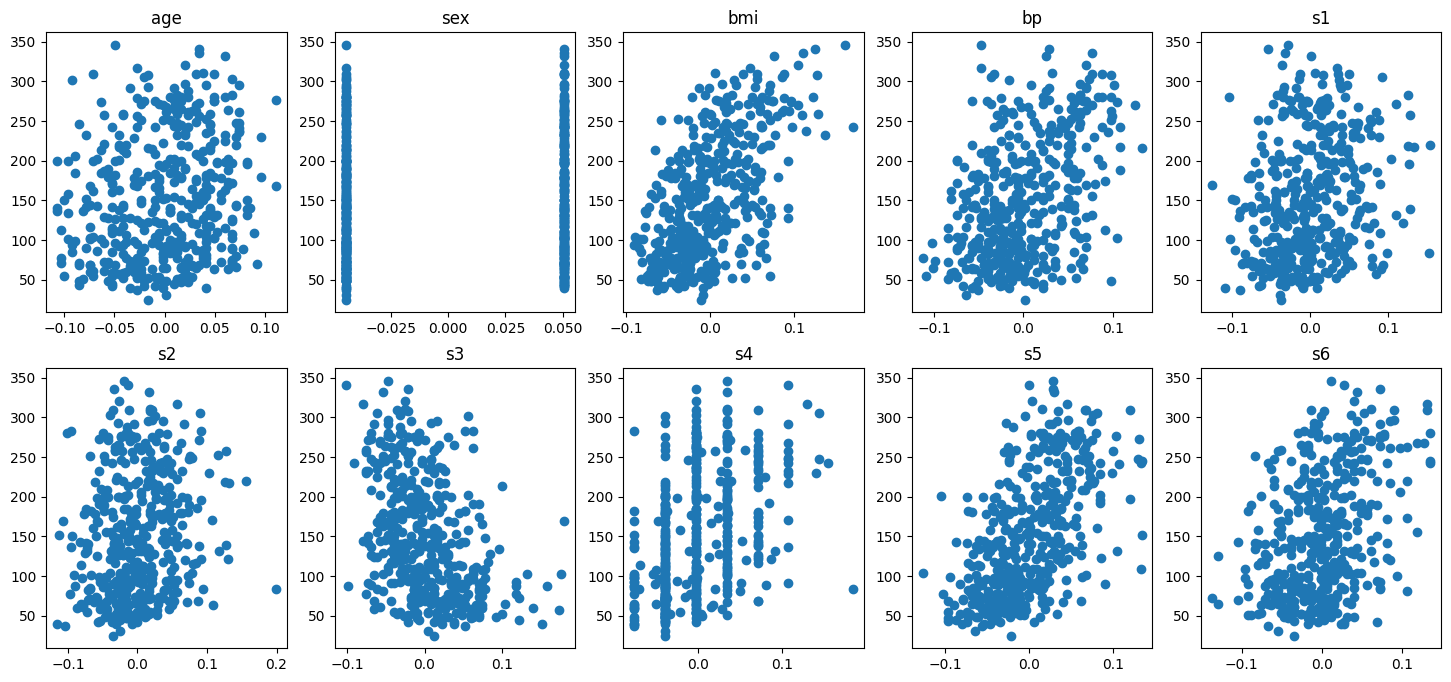

In [ ]:
fig = plt.figure(figsize=(18, 8))
for i, feat in enumerate(df):
  plt.subplot(2, 5, i + 1)
  plt.scatter(df[feat], target)
  plt.title(feat)

Datos para la validación.

In [ ]:
X = df.to_numpy()
y = target.to_numpy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=random_seed)

## Regresor
PyTorch requiere que cada red neuronal sea una subclase de la clase `nn.Module`, y solo nos pide definir dos métodos:

In [ ]:
class Regressor(nn.Module):
  def __init__(self) -> None: #Definimos las capas que usaremos.
    super().__init__()
    self.linear = nn.Linear(10, 1)

  def forward(self, x: torch.Tensor) -> torch.Tensor: # Define cómo nuestras capas van a interactuar.
    x = self.linear(x)
    return torch.ravel(x)

PyTorch ofrece un mayor nivel de flexibilidad y control en comparación con TensorFlow, lo que permite a los desarrolladores personalizar su ciclo de entrenamiento y ajustarlo según sus necesidades. La atención a los detalles, como cambiar al modo de entrenamiento y limpiar los gradientes, es esencial para un entrenamiento exitoso en PyTorch.

In [ ]:
def train(dataloader: DataLoader, model: nn.Module, loss_fn, optimizer) -> float:
  model.train()
  epoch_loss = 0.0

  for batch, (X, y) in enumerate(dataloader):
    p = model(X)
    loss = loss_fn(p, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    epoch_loss += loss.item()
  return epoch_loss / len(dataloader)

Ahora, definamos el método para pruebas. Nuevamente requerimos de un `DataLoader`, del modelo y la función de pérdida pero no del optimizador. Para realizar inferencia, es necesario activar el método de evaluación con `model.eval()` pero aparte de eso **desactive los gradientes** con `torch.no_grad()`.

In [ ]:
def test(dataloader: DataLoader, model: nn.Module, loss_fn) -> float:
  model.eval()
  test_loss = 0.0

  with torch.no_grad():
    for X, y in dataloader:
      p = model(X)
      test_loss += loss_fn(p, y).item()
  return test_loss / len(dataloader)

Cargamos el dataset de entrenamiento y validación como tensores de PyTorch en lugar de Numpy, y al final nos ayudaremos de las clases `TensorDataset` y `DataLoader` para cargarlos de la manera correcta.

In [ ]:
X_train, y_train = torch.Tensor(X_train, device=device), torch.Tensor(y_train, device=device)
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)

In [ ]:
X_val, y_val = torch.Tensor(X_val, device=device), torch.Tensor(y_val, device=device)
val_dataset = TensorDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=20, shuffle=True)

In [ ]:
# Entrenaremos por 50 épocas
epochs = 100

regressor = Regressor()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(regressor.parameters(), lr=0.001)

# En cada iteración guardaremos la función de pérdida por cuestiones de
# visualización
train_history = []
val_history = []

# Repetimos este proceso para cada época
for t in range(epochs):
  # Calculamos MSE tanto para el conjunto de entrenamiento como el de
  # validación y lo guardamos
  train_loss = train(train_dataloader, regressor, loss_fn, optimizer)
  val_loss = test(val_dataloader, regressor, loss_fn)
  train_history.append(train_loss)
  val_history.append(val_loss)

print('Done!')

Done!


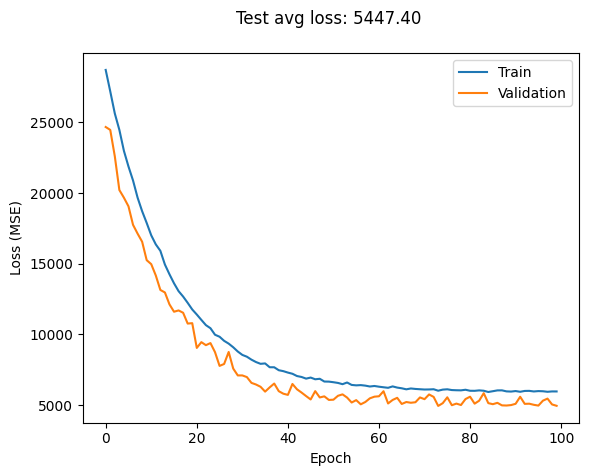

In [ ]:
val_test = test(val_dataloader, regressor, loss_fn)
plt.title(f'Test avg loss: {val_test:>.2f} \n')
plt.plot(train_history, label='Train')
plt.plot(val_history, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend();